# Análisis exploratorio de datos (EDA)

In [1]:
library(tidyverse)
library(Amelia)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.8.1, built: 2022-11-18)
## Copyright (C) 2005-2022 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 



In [2]:
df = read.csv("data/train.csv", header = TRUE)
head(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False
2,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True
3,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False
4,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False
5,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True
6,0005_01,Earth,False,F/0/P,PSO J318.5-22,44,False,0,483,0,291,0,Sandie Hinetthews,True


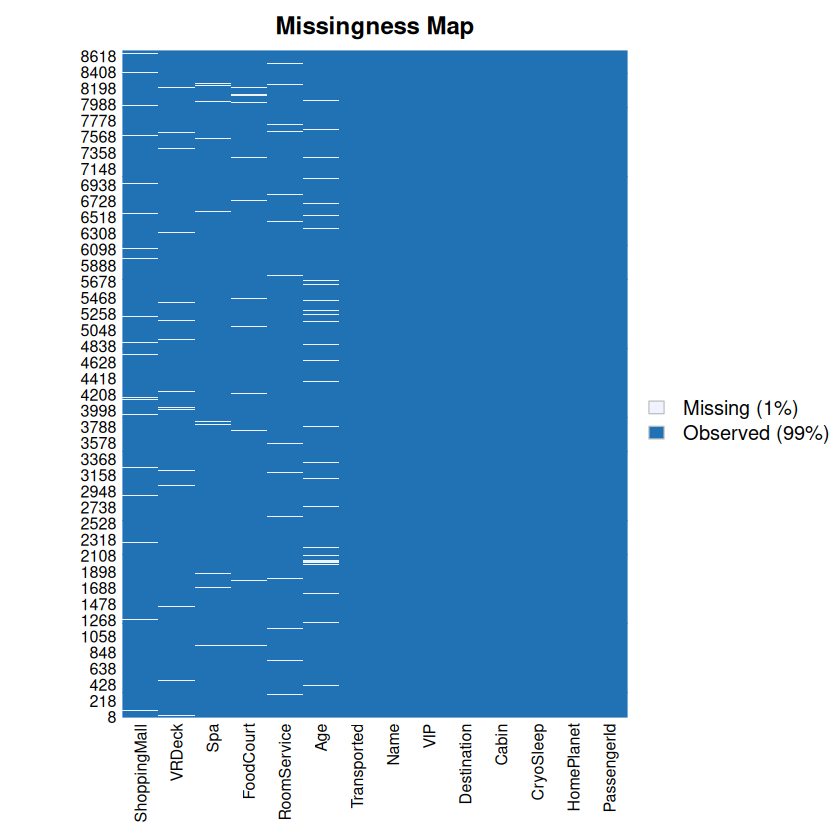

In [3]:
missmap(df)

In [4]:
print(table(df$HomePlanet))
print(table(df$Destination))
print(table(df$CryoSleep))
print(table(df$VIP))


        Earth Europa   Mars 
   201   4602   2131   1759 

                55 Cancri e PSO J318.5-22   TRAPPIST-1e 
          182          1800           796          5915 

      False  True 
  217  5439  3037 

      False  True 
  203  8291   199 


In [5]:
splitted = str_split(df$Cabin, '/', simplify = TRUE)

In [6]:
table(splitted[, 1])


        A    B    C    D    E    F    G    T 
 199  256  779  747  478  876 2794 2559    5 

In [7]:
table(splitted[, 3])


        P    S 
 199 4206 4288 

In [8]:
df = df %>% mutate(Cabin_deck = splitted[, 1], 
                   Cabin_num = as.integer(splitted[, 2]), 
                   Cabin_side = splitted[, 3]) %>% select(-Cabin)
head(df)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_num,Cabin_side
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>
1,0001_01,Europa,False,TRAPPIST-1e,39,False,0,0,0,0,0,Maham Ofracculy,False,B,0,P
2,0002_01,Earth,False,TRAPPIST-1e,24,False,109,9,25,549,44,Juanna Vines,True,F,0,S
3,0003_01,Europa,False,TRAPPIST-1e,58,True,43,3576,0,6715,49,Altark Susent,False,A,0,S
4,0003_02,Europa,False,TRAPPIST-1e,33,False,0,1283,371,3329,193,Solam Susent,False,A,0,S
5,0004_01,Earth,False,TRAPPIST-1e,16,False,303,70,151,565,2,Willy Santantines,True,F,1,S
6,0005_01,Earth,False,PSO J318.5-22,44,False,0,483,0,291,0,Sandie Hinetthews,True,F,0,P


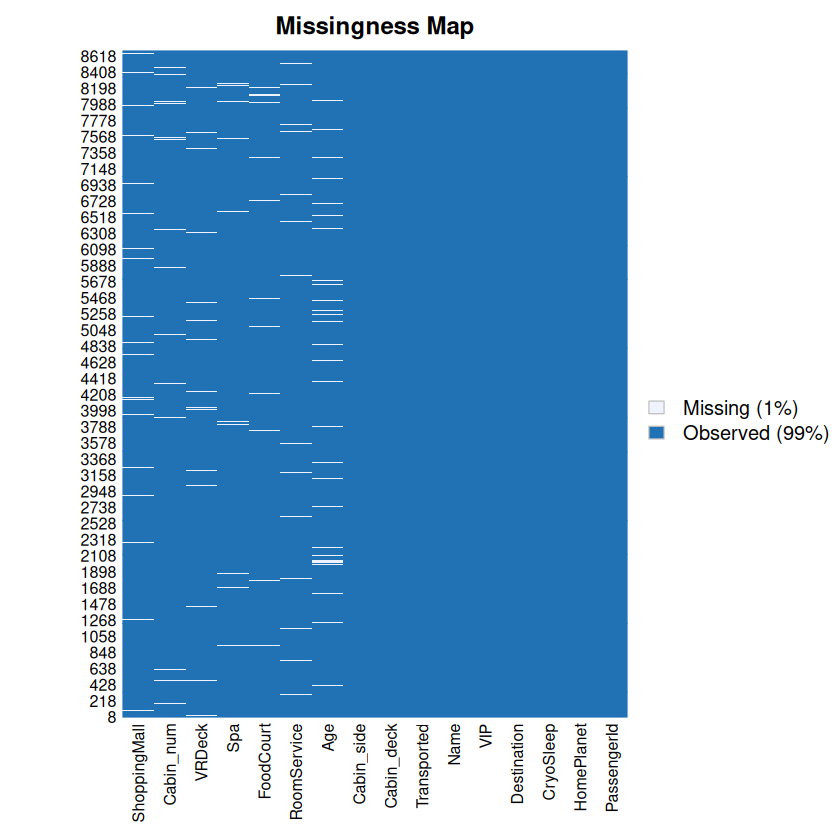

In [9]:
missmap(df)

In [10]:
df$Cabin_deck[df$Cabin_deck == ""] = NA
df$Cabin_num[df$Cabin_num == ""] = NA
df$Cabin_side[df$Cabin_side == ""] = NA
df$HomePlanet[df$HomePlanet == ""] = NA
df$Destination[df$Destination == ""] = NA
df$CryoSleep[df$CryoSleep == ""] = NA
df$VIP[df$VIP == ""] = NA

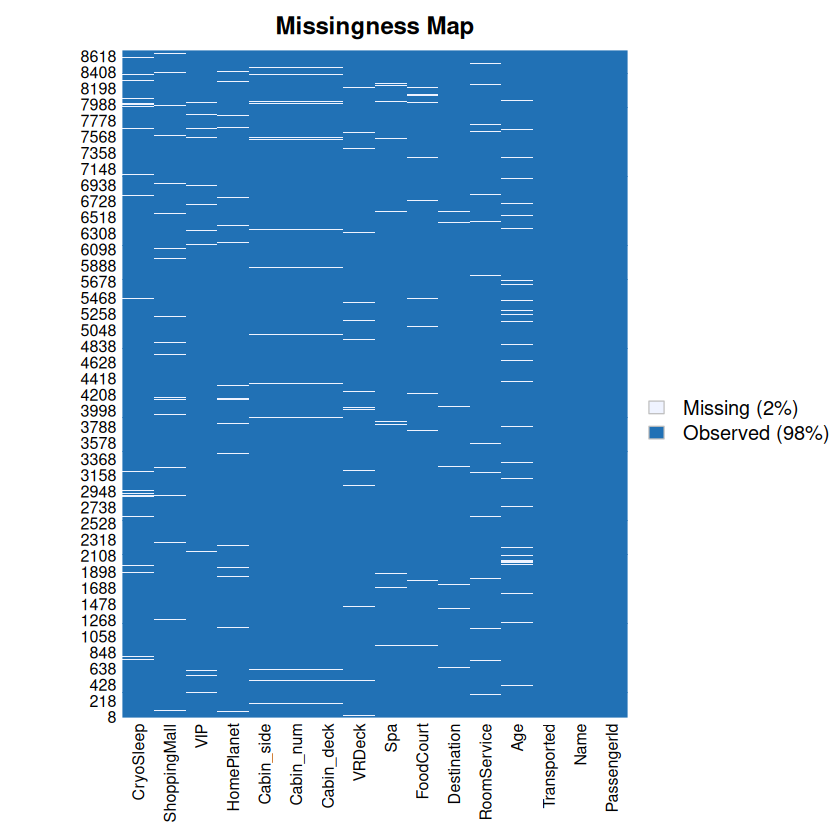

In [11]:
missmap(df)

In [12]:
mode_hp = (df %>% group_by(HomePlanet) %>% summarize(n = n()) %>% na.omit %>% top_n(1))$HomePlanet
mode_cabin_deck = (df %>% group_by(Cabin_deck) %>% summarize(n = n()) %>% na.omit %>% top_n(1))$Cabin_deck
mode_cabin_side = (df %>% group_by(Cabin_side) %>% summarize(n = n()) %>% na.omit %>% top_n(1))$Cabin_side
mode_dest = (df %>% group_by(Destination) %>% summarize(n = n()) %>% na.omit %>% top_n(1))$Destination
mode_cs = (df %>% group_by(CryoSleep) %>% summarize(n = n()) %>% na.omit %>% top_n(1))$CryoSleep
mode_vip = (df %>% group_by(VIP) %>% summarize(n = n()) %>% na.omit %>% top_n(1))$VIP


Selecting by n
Selecting by n
Selecting by n
Selecting by n
Selecting by n
Selecting by n


In [13]:

df_mode = data.frame(mode_hp = mode_hp, mode_cabin_deck = mode_cabin_deck, mode_cabin_side = mode_cabin_side, mode_cs = mode_cs, mode_vip = mode_vip, mode_dest = mode_dest)
df_mode

mode_hp,mode_cabin_deck,mode_cabin_side,mode_cs,mode_vip,mode_dest
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Earth,F,S,False,False,TRAPPIST-1e


In [14]:
df$Cabin_deck[is.na(df$Cabin_deck)] = mode_cabin_deck
df$Cabin_side[is.na(df$Cabin_side)] = mode_cabin_side
df$HomePlanet[is.na(df$HomePlanet)] = mode_hp
df$Destination[is.na(df$Destination)] = mode_dest
df$CryoSleep[is.na(df$CryoSleep)] = mode_cs
df$VIP[is.na(df$VIP)] = mode_vip

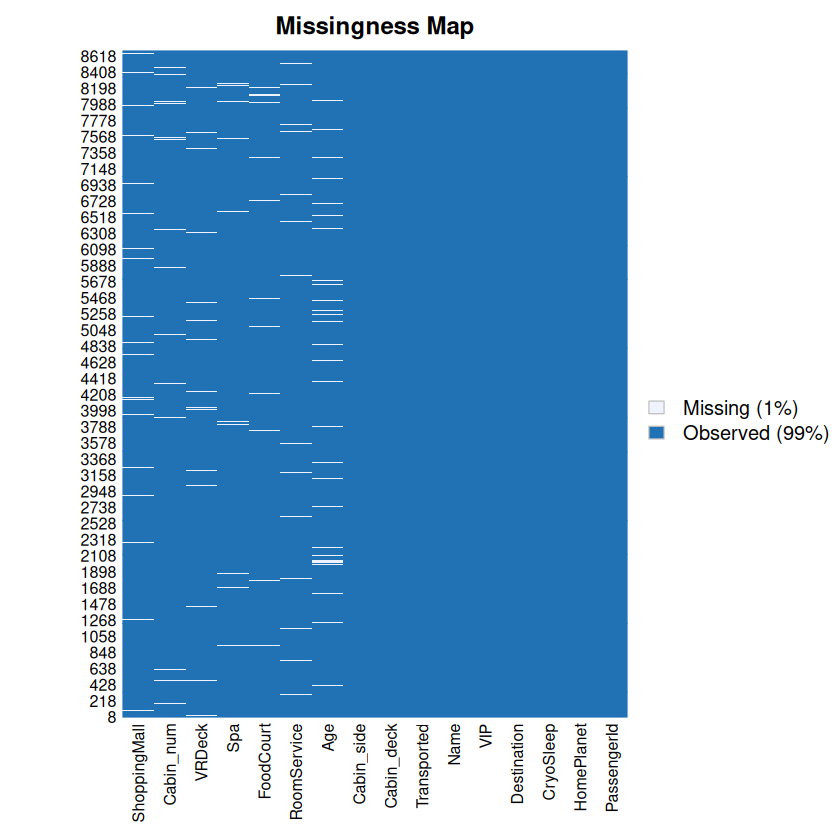

In [15]:
missmap(df)

In [ ]:
ggplot(df, aes(x = Destination)) +
    geom_bar() +
    facet_wrap(~Transported)

In [ ]:
ggplot(df, aes(x = HomePlanet)) +
    geom_bar() +
    facet_wrap(~Transported)